# Background check for semi-supervised learning

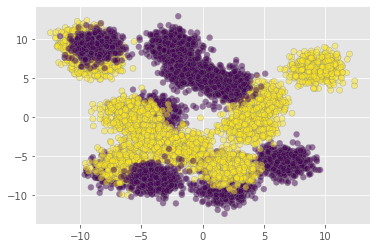

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone

plt.style.use('ggplot')
plt.rcParams["savefig.format"] = 'svg'
plt.rcParams['image.cmap'] = 'viridis'

np.random.seed(42)

#x, y = make_classification(n_samples=10000, n_features=2, n_informative=5, n_redundant=0, n_clusters_per_class=4)

n_samples=10000
n_features=2
centers=20
x, blob_id = make_blobs(n_samples=n_samples, n_features=n_features,
                        centers=centers, shuffle=False)
y = blob_id%2

plt.scatter(x[:,0], x[:,1], c=y, alpha=0.5, edgecolor='grey')
dataset_name = 'blobs_s_{}_f_{}_c_{}'.format(n_samples, n_features, centers)
plt.savefig('dataset_{}'.format(dataset_name))

<BarContainer object of 2 artists>

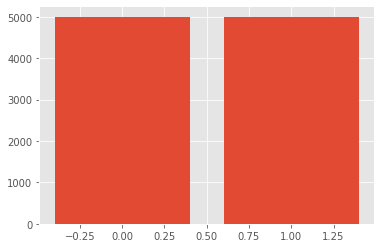

In [2]:
classes, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts)

In [3]:
# generation of a grid for later model exploration
# define bounds of the domain
min1, max1 = x[:, 0].min()-1, x[:, 0].max()+1
min2, max2 = x[:, 1].min()-1, x[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# Labelled and unlabelled data

We can generate unlabelled data by selecting a subset of the original data and dropping its labels. We will generate the unlabelled data from two different forms:

1. IID: Uniformly random from the labelled distribution
2. OOD: Non-uniformly random from the labelled distribution

In this example, given that the samples are sorted by blobs, we can split the data into two parts for option (2), or shuffle the data and split for option (1).

1. IID: shuffle=True
2. OOD: shuffle=False

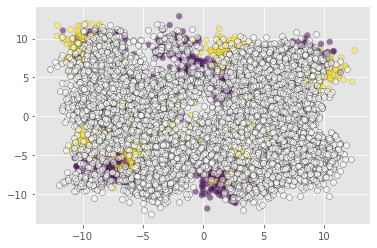

In [4]:
shuffle=True
dataset_name += '_iid' if shuffle else '_ood'

x_label, x_unlabel, y_label, y_unlabel = train_test_split(x, y, test_size=0.7, shuffle=shuffle)

plt.scatter(x_label[:,0], x_label[:,1], c=y_label, edgecolor='grey', alpha=0.5)
plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black', alpha=0.5)
plt.savefig('semi_{}'.format(dataset_name))

<BarContainer object of 2 artists>

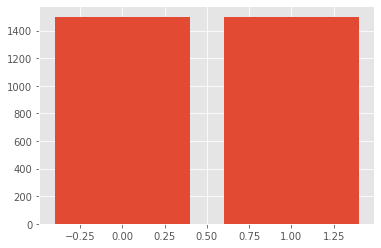

In [5]:
classes, counts = np.unique(y_label, return_counts=True)
plt.bar(classes, counts)

## Supervised model

In the subset of labeled data we can train a probabilistic classifier, and check the prediction space.

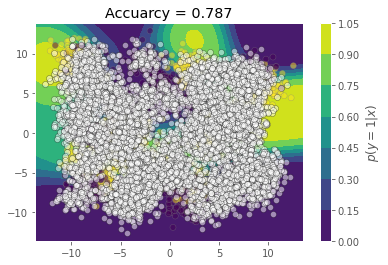

In [6]:
from sklearn.svm import SVC

classifier_dict = {'svm_rbf': SVC(kernel='rbf', probability=True)}

clf_name = 'svm_rbf'

# TODO: Check what happens when I do not clone.
#clf = classifier_dict[clf_name]
clf = clone(classifier_dict[clf_name])

clf.fit(x_label, y_label)

# make predictions for the grid
yhat = clf.predict_proba(grid)[:,1]
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz)
plt.colorbar(label='$p(y=1|x)$')
plt.scatter(x_label[:,0], x_label[:,1], c=y_label, edgecolors='grey',
            alpha=0.5)
plt.scatter(x_unlabel[:,0], x_unlabel[:,1], c='white', edgecolors='black',
            alpha=0.5)
plt.title('Accuarcy = {:0.3f}'.format(accuracy_score(y_label, clf.predict(x_label))))
plt.savefig('{}_clf_{}'.format(dataset_name, clf_name))

We define a function to compute a given metric function to the rejected, and accepted samples from a full range of an arbitrary sorting value.

In [7]:
def function_vs_reject(ground_truth, predictions, thresholds, func=accuracy_score):
    thresholds_sort_idx = np.argsort(-1*thresholds)
    predictions_sorted = predictions[thresholds_sort_idx]
    ground_truth_sorted = ground_truth[thresholds_sort_idx]
    accepted = np.zeros(thresholds.shape[0])
    rejected = np.zeros(thresholds.shape[0])
    samples = np.zeros(thresholds.shape[0])
    for i, threshold_id in enumerate(thresholds_sort_idx):
        threshold = thresholds[threshold_id]
        rejected[i] = func(ground_truth_sorted[i:], predictions_sorted[i:])
        accepted[i] = func(ground_truth_sorted[:i], predictions_sorted[:i])
        samples[i] = ground_truth_sorted[:i].shape[0]
            

    return accepted, rejected, samples, thresholds[thresholds_sort_idx]

Here, we will sort the accepted samples by the confidence of the binary classifier's prediction (maximum posterior probability per sample). We will show the accuracy of the accepted and rejected samples.

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: Und

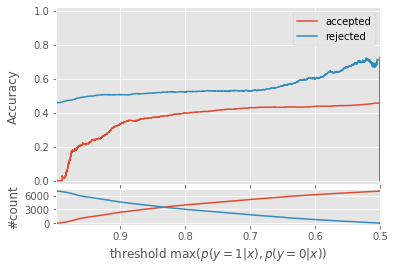

In [8]:
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import f1_score

func=f1_score

x_aux = x_unlabel
y_aux = y_unlabel

predictions = clf.predict(x_aux)
p_conf = np.max(clf.predict_proba(x_aux), axis=1)

accepted, rejected, samples, sorting_value = function_vs_reject(y_aux, predictions, p_conf,
                                                                func=func)

spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[5, 1],
                         wspace=0.02, hspace=0.05, left=0.15)
fig = plt.figure()
ax = fig.add_subplot(spec[0])
ax.plot(sorting_value, accepted, label='accepted')
ax.plot(sorting_value, rejected, label='rejected')
ax.set_ylabel('Accuracy')
ax.set_xticklabels([])
ax.set_xlim([sorting_value.max(), sorting_value.min()])
ax.set_ylim([-0.02, 1.02])
ax.legend()
ax = fig.add_subplot(spec[1])
ax.plot(sorting_value, samples)
ax.plot(sorting_value, samples.max() - samples)
ax.set_ylabel('#count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', nbins=3))
ax.set_xlabel('threshold max$(p(y=1|x), p(y=0|x))$')
ax.set_xlim([sorting_value.max(), sorting_value.min()])
fig.align_labels()
fig.savefig('')
plt.savefig('{}_clf_{}_conf_reject'.format(dataset_name, clf_name))

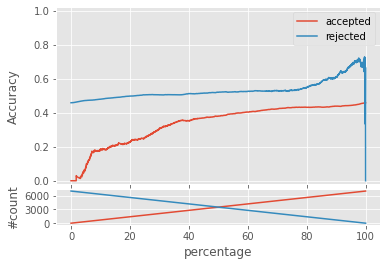

In [9]:
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[5, 1],
                         wspace=0.02, hspace=0.05, left=0.15)

percentage = np.linspace(0, 100, x_aux.shape[0])

fig = plt.figure()
ax = fig.add_subplot(spec[0])
ax.plot(percentage, accepted, label='accepted')
ax.plot(percentage, rejected, label='rejected')
ax.set_ylabel('Accuracy')
ax.set_xticklabels([])
#ax.set_xlim([sorting_value.max(), sorting_value.min()])
ax.set_ylim([-0.02, 1.02])
ax.legend()
ax = fig.add_subplot(spec[1])
ax.plot(percentage, samples)
ax.plot(percentage, samples.max() - samples)
ax.set_ylabel('#count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', nbins=3))
ax.set_xlabel('percentage')
#ax.set_xlim([sorting_value.max(), sorting_value.min()])
fig.align_labels()
plt.savefig('{}_clf_{}_conf_reject_perc'.format(dataset_name, clf_name))

# Labelled vs unlabelled

We will focus now on the labelled vs unlabelled data (not distinguishing between classes).

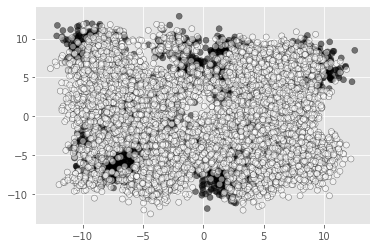

In [10]:
x_l_vs_u = np.concatenate([x_label, x_unlabel])
y_l_vs_u = np.concatenate([np.ones(x_label.shape[0]), np.zeros(x_unlabel.shape[0])])

plt.scatter(x_l_vs_u[:,0], x_l_vs_u[:,1], c=y_l_vs_u, cmap='binary',
            edgecolor='k', alpha=0.5)
plt.savefig('{}_lab_vs_unl'.format(dataset_name))

## Supervised model

to differentiate between samples with or without a label. If the samples are difficult to differentiate, we can expect both labelled and unlabelled data comming from the same data distribution. On the oposite case, if the model is able to predict from which set different sample come, is indicative of out of distribution data, for which we should not make clear assumptions.

In [11]:
clf_fg_name = 'svm_rbf'

# TODO: Check what happens when I do not clone
# clf_fg = classifier_dict[clf_name]
clf_fg = clone(classifier_dict[clf_name])

clf_fg.fit(x_l_vs_u, y_l_vs_u)

SVC(probability=True)

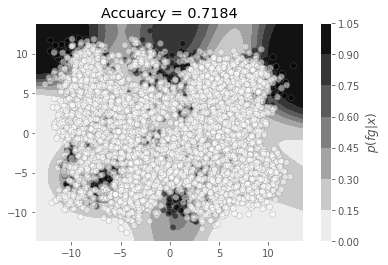

In [12]:
# make predictions for the grid
yhat = clf_fg.predict_proba(grid)[:,1]
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='binary')
plt.colorbar(label='$p(fg|x)$')
plt.scatter(x_l_vs_u[:,0], x_l_vs_u[:,1], c=y_l_vs_u, cmap='binary',
            edgecolor='grey', alpha=0.5)
plt.title('Accuarcy = {}'.format(accuracy_score(y_l_vs_u, clf_fg.predict(x_l_vs_u))));
plt.savefig('{}_clf_fg_{}'.format(dataset_name, clf_name))

Here, we will sort the accepted samples by the posterior probability of belonging to the same distribution as the labelled samples. We will show the accuracy of the accepted and rejected samples.

/home/mp15688/git/machine_learning_concepts/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


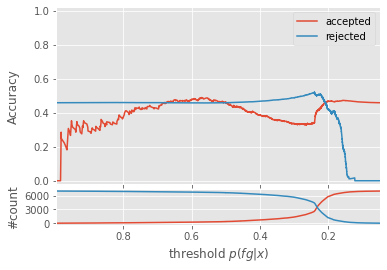

In [13]:
predictions = clf.predict(x_aux)
p_fg = clf_fg.predict_proba(x_aux)[:,1]

accepted, rejected, samples, sorting_value = function_vs_reject(y_aux, predictions, p_fg,
                                                                func=func)

spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[5, 1],
                         wspace=0.02, hspace=0.05, left=0.15)
fig = plt.figure()
ax = fig.add_subplot(spec[0])
ax.plot(sorting_value, accepted, label='accepted')
ax.plot(sorting_value, rejected, label='rejected')
ax.set_ylabel('Accuracy')
ax.set_xticklabels([])
ax.set_xlim([sorting_value.max(), sorting_value.min()])
ax.set_ylim([-0.02, 1.02])
ax.legend()
ax = fig.add_subplot(spec[1])
ax.plot(sorting_value, samples)
ax.plot(sorting_value, samples.max() - samples)
ax.set_ylabel('#count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', nbins=3))
ax.set_xlabel('threshold $p(fg|x)$')
ax.set_xlim([sorting_value.max(), sorting_value.min()])
fig.align_labels()
plt.savefig('{}_clf_{}_bg_reject_{}'.format(dataset_name, clf_name, clf_fg_name))

The same figure but with percentage in the x-axis instead of posterior probabilities.

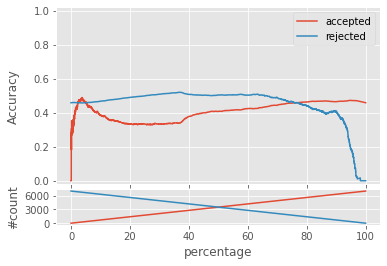

In [14]:
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[5, 1],
                         wspace=0.02, hspace=0.05, left=0.15)

percentage = np.linspace(0, 100, x_aux.shape[0])

fig = plt.figure()
ax = fig.add_subplot(spec[0])
ax.plot(percentage, accepted, label='accepted')
ax.plot(percentage, rejected, label='rejected')
ax.set_ylabel('Accuracy')
ax.set_xticklabels([])
#ax.set_xlim([sorting_value.max(), sorting_value.min()])
ax.set_ylim([-0.02, 1.02])
ax.legend()
ax = fig.add_subplot(spec[1])
ax.plot(percentage, samples)
ax.plot(percentage, samples.max() - samples)
ax.set_ylabel('#count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', nbins=3))
ax.set_xlabel('percentage')
#ax.set_xlim([sorting_value.max(), sorting_value.min()])
fig.align_labels()
plt.savefig('{}_clf_{}_bg_reject_{}_perc'.format(dataset_name, clf_name, clf_fg_name))